# SVG Coordinate Extraction Verification

This notebook overlays the original SVG rendering with the extracted coordinates to visually verify that the coordinate conversion in `svg-parser.js` is correct.

In [4]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import re
import math
from pathlib import Path
from IPython.display import SVG, display

## 1. Load and display the original SVG

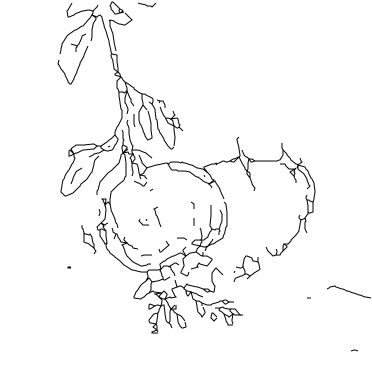

In [5]:
SVG_PATH = Path("outputfile.svg")
svg_text = SVG_PATH.read_text()

# Show the raw SVG
display(SVG(svg_text))

## 2. Parse SVG elements into coordinates

This replicates the same logic as `svg-parser.js` — extracting points from `<polyline>`, `<polygon>`, `<line>`, `<path>` elements, and connecting separate segments with interpolated bridge points.

In [6]:
def parse_svg_coords(svg_path):
    """Parse SVG file and extract coordinates from all geometric elements.
    
    Mirrors the logic in svg-parser.js:
    - <polyline> / <polygon>: parse points attribute
    - <line>: interpolate between endpoints
    - <path>: basic M/L/Z command support
    
    Returns:
        segments: list of lists of (x, y) tuples — one list per element
        all_points: flat list of (x, y) with bridge interpolation between segments
        viewbox: (x, y, w, h) from the SVG viewBox
    """
    tree = ET.parse(svg_path)
    root = tree.getroot()
    
    # Handle SVG namespace
    ns = {'svg': 'http://www.w3.org/2000/svg'}
    
    # Get viewBox
    vb = root.get('viewBox', '0 0 100 100')
    vb_parts = list(map(float, vb.split()))
    viewbox = tuple(vb_parts)
    
    segments = []
    
    # Find all elements (handle namespace)
    def find_all(tag):
        # Try with namespace
        found = root.findall(f'.//{{{ns["svg"]}}}{tag}')
        if not found:
            found = root.findall(f'.//{tag}')
        return found
    
    # 1. Parse <polyline> and <polygon> elements
    for tag in ['polyline', 'polygon']:
        for el in find_all(tag):
            pts_str = el.get('points', '')
            if not pts_str.strip():
                continue
            nums = list(map(float, re.split(r'[\s,]+', pts_str.strip())))
            seg = []
            for i in range(0, len(nums) - 1, 2):
                seg.append((nums[i], nums[i + 1]))
            if seg:
                segments.append(seg)
    
    # 2. Parse <line> elements
    for el in find_all('line'):
        x1 = float(el.get('x1', 0))
        y1 = float(el.get('y1', 0))
        x2 = float(el.get('x2', 0))
        y2 = float(el.get('y2', 0))
        dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        steps = max(5, round(dist))
        seg = []
        for t in range(steps + 1):
            frac = t / steps
            seg.append((x1 + (x2 - x1) * frac, y1 + (y2 - y1) * frac))
        segments.append(seg)
    
    # 3. Parse <path> elements (basic M/L/Z support)
    for el in find_all('path'):
        d = el.get('d', '')
        seg = []
        # Very basic parser for M, L, Z commands
        tokens = re.findall(r'[MLZmlz]|[-+]?\d*\.?\d+', d)
        cmd = 'M'
        i = 0
        while i < len(tokens):
            if tokens[i] in 'MLZmlz':
                cmd = tokens[i]
                i += 1
            if cmd in ('M', 'L'):
                if i + 1 < len(tokens):
                    seg.append((float(tokens[i]), float(tokens[i+1])))
                    i += 2
                    if cmd == 'M':
                        cmd = 'L'  # implicit lineto after moveto
                else:
                    i += 1
            elif cmd in ('m', 'l'):
                if i + 1 < len(tokens) and seg:
                    dx, dy = float(tokens[i]), float(tokens[i+1])
                    last = seg[-1]
                    seg.append((last[0] + dx, last[1] + dy))
                    i += 2
                    if cmd == 'm':
                        cmd = 'l'
                else:
                    i += 1
            elif cmd in ('Z', 'z'):
                if seg:
                    seg.append(seg[0])  # close path
                i += 1
            else:
                i += 1
        if seg:
            segments.append(seg)
    
    # Connect segments with bridge points (same as svg-parser.js)
    all_points = []
    for s_idx, seg in enumerate(segments):
        if s_idx > 0 and all_points:
            last_pt = all_points[-1]
            first_pt = seg[0]
            dx = first_pt[0] - last_pt[0]
            dy = first_pt[1] - last_pt[1]
            dist = math.sqrt(dx*dx + dy*dy)
            bridge_steps = max(5, round(dist / 2))
            for b in range(1, bridge_steps + 1):
                frac = b / bridge_steps
                all_points.append((last_pt[0] + dx * frac, last_pt[1] + dy * frac))
        all_points.extend(seg)
    
    return segments, all_points, viewbox

segments, all_points, viewbox = parse_svg_coords(SVG_PATH)
print(f"ViewBox: {viewbox}")
print(f"Segments: {len(segments)}")
print(f"Total points (with bridges): {len(all_points)}")
print(f"Raw points (no bridges): {sum(len(s) for s in segments)}")

ViewBox: (0.0, 0.0, 372.0, 372.0)
Segments: 108
Total points (with bridges): 3155
Raw points (no bridges): 1596


## 3. Overlay: SVG paths vs extracted coordinates

The **blue lines** are the original SVG polylines/lines drawn directly from the SVG elements.  
The **red dots** are the extracted coordinate points (same data the Fourier transform receives).  
If the conversion is correct, the red dots should sit exactly on the blue lines.

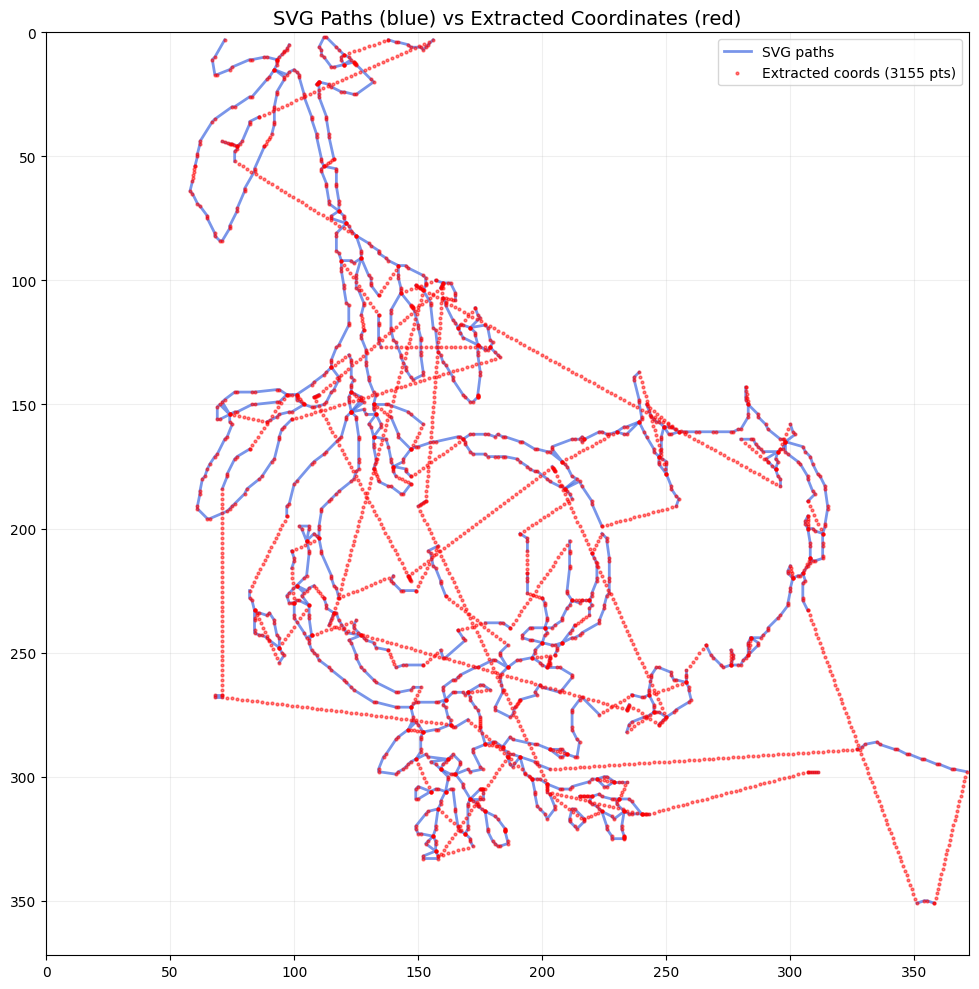

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Draw original SVG segments as blue lines
for i, seg in enumerate(segments):
    xs = [p[0] for p in seg]
    ys = [p[1] for p in seg]
    ax.plot(xs, ys, color='royalblue', linewidth=2, alpha=0.7,
            label='SVG paths' if i == 0 else None)

# Overlay extracted coordinates as red dots
all_x = [p[0] for p in all_points]
all_y = [p[1] for p in all_points]
ax.scatter(all_x, all_y, color='red', s=4, alpha=0.5, zorder=5,
           label=f'Extracted coords ({len(all_points)} pts)')

# Match SVG coordinate system (y increases downward)
ax.set_xlim(viewbox[0], viewbox[0] + viewbox[2])
ax.set_ylim(viewbox[1] + viewbox[3], viewbox[1])  # flip y-axis
ax.set_aspect('equal')
ax.set_title('SVG Paths (blue) vs Extracted Coordinates (red)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

## 4. Traversal path — point order visualization

Shows how the points are connected in order (including bridge segments between polylines). The color gradient goes from **yellow (start)** to **purple (end)** so you can see the drawing order.

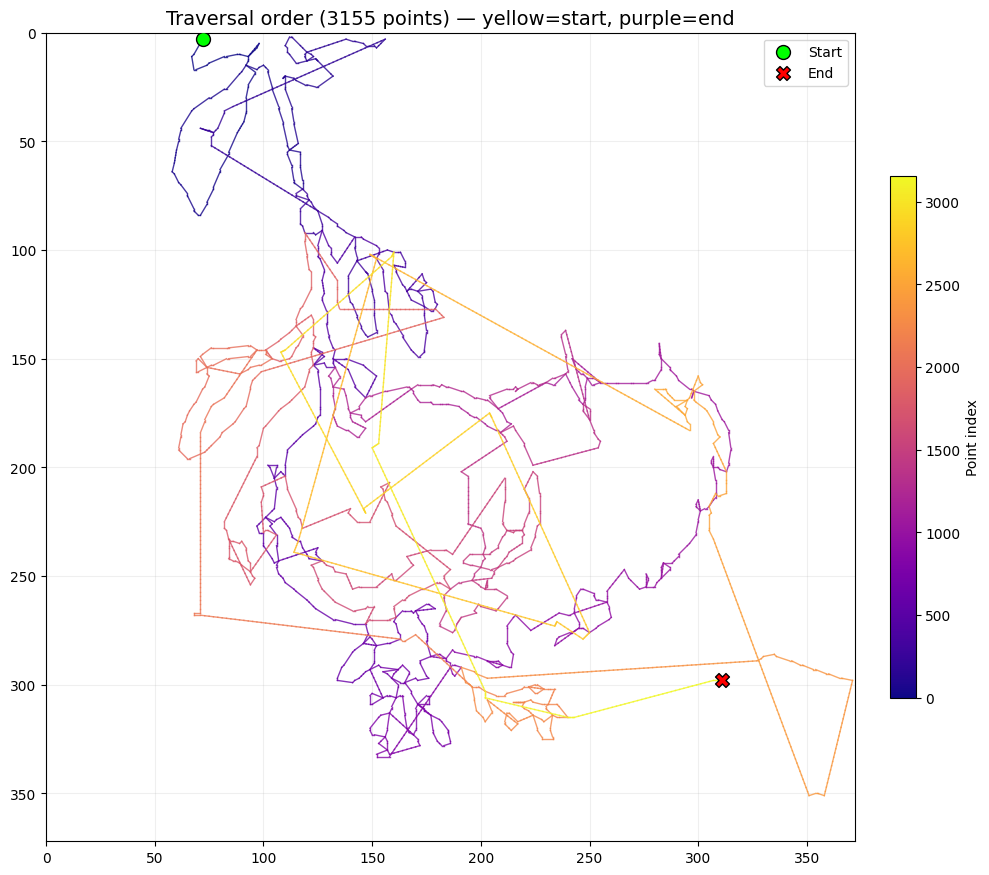

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

all_x = np.array([p[0] for p in all_points])
all_y = np.array([p[1] for p in all_points])
n = len(all_points)

# Draw connected path colored by traversal order
for i in range(n - 1):
    t = i / max(n - 1, 1)
    color = plt.cm.plasma(t)
    ax.plot([all_x[i], all_x[i+1]], [all_y[i], all_y[i+1]],
            color=color, linewidth=1, alpha=0.8)

# Mark start and end
ax.scatter([all_x[0]], [all_y[0]], color='lime', s=100, zorder=10,
           edgecolors='black', label='Start')
ax.scatter([all_x[-1]], [all_y[-1]], color='red', s=100, zorder=10,
           edgecolors='black', marker='X', label='End')

ax.set_xlim(viewbox[0], viewbox[0] + viewbox[2])
ax.set_ylim(viewbox[1] + viewbox[3], viewbox[1])
ax.set_aspect('equal')
ax.set_title(f'Traversal order ({n} points) — yellow=start, purple=end', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.2)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(0, n))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Point index')

plt.tight_layout()
plt.show()

## 5. Per-segment breakdown

Each original SVG element (polyline/line) shown in a different color, with bridge segments in dashed gray.

/var/folders/tg/56s9qq957lv6l5m404361hlh0000gn/T/ipykernel_97747/3704959805.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(segments))


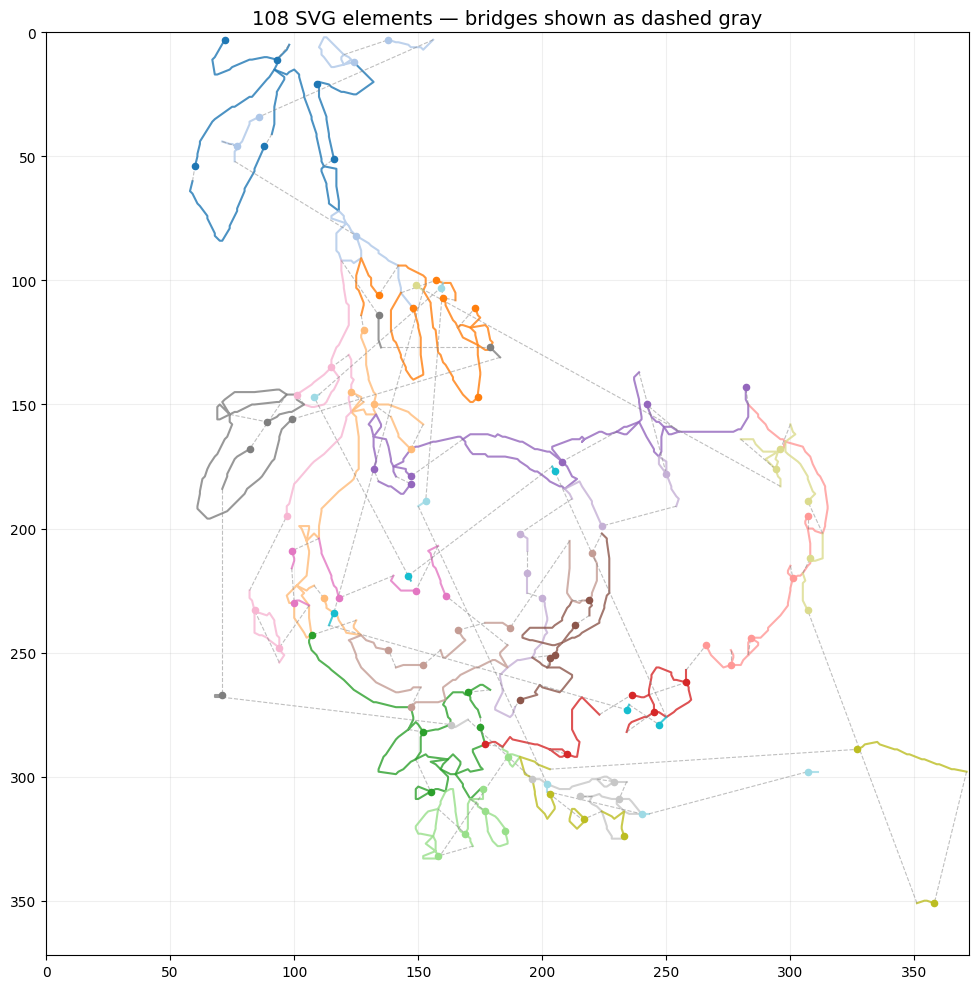


Segment summary:
  Segment   0:   16 points | (72,3) → (98,5)
  Segment   1:   14 points | (93,11) → (91,41)
  Segment   2:   20 points | (88,46) → (59,60)
  Segment   3:   46 points | (60,54) → (112,54)
  Segment   4:    8 points | (116,51) → (110,20)
  Segment   5:   12 points | (109,21) → (125,13)
  Segment   6:   22 points | (124,12) → (120,9)
  Segment   7:   10 points | (138,3) → (156,3)
  Segment   8:   10 points | (86,34) → (71,44)
  Segment   9:    4 points | (77,46) → (76,52)
  Segment  10:   42 points | (125,82) → (147,110)
  Segment  11:   22 points | (148,111) → (143,105)
  Segment  12:    8 points | (157,100) → (165,108)
  Segment  13:   18 points | (160,107) → (166,119)
  Segment  14:   20 points | (173,111) → (174,146)
  Segment  15:   24 points | (174,147) → (142,94)
  Segment  16:   14 points | (134,106) → (127,114)
  Segment  17:   18 points | (128,120) → (152,158)
  Segment  18:    4 points | (147,168) → (139,155)
  Segment  19:   10 points | (132,150) → (128,149)


In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

cmap = plt.cm.get_cmap('tab20', len(segments))

for i, seg in enumerate(segments):
    xs = [p[0] for p in seg]
    ys = [p[1] for p in seg]
    color = cmap(i)
    ax.plot(xs, ys, color=color, linewidth=1.5, alpha=0.8)
    # Mark first point of each segment
    ax.scatter([xs[0]], [ys[0]], color=color, s=20, zorder=5)

# Draw bridge connections in dashed gray
for i in range(1, len(segments)):
    prev_end = segments[i-1][-1]
    curr_start = segments[i][0]
    ax.plot([prev_end[0], curr_start[0]], [prev_end[1], curr_start[1]],
            color='gray', linewidth=0.8, linestyle='--', alpha=0.5)

ax.set_xlim(viewbox[0], viewbox[0] + viewbox[2])
ax.set_ylim(viewbox[1] + viewbox[3], viewbox[1])
ax.set_aspect('equal')
ax.set_title(f'{len(segments)} SVG elements — bridges shown as dashed gray', fontsize=14)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print(f"\nSegment summary:")
for i, seg in enumerate(segments):
    print(f"  Segment {i:3d}: {len(seg):4d} points | "
          f"({seg[0][0]:.0f},{seg[0][1]:.0f}) → ({seg[-1][0]:.0f},{seg[-1][1]:.0f})")